In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from IPython.display import display

## Initialize student pool based on above parameters
def disadvantaged_random():
    val = np.random.random()
    if (val) >= 0.67:
        return 1
    else:
        return 0

def advantaged_random():
    val = np.random.random()
    if (val) >= 0.34:
        return 1
    else: 
        return 0

def print_equity(num_A,num_D):
    # print('assessing equity: ')
    # print('% of students from A: ',100*(num_A/(num_A+num_D)))
    # print('% of students from D: ',100*(num_D/(num_A+num_D)))

    return num_A/(num_A+num_D)

# Meeting Todo (2/11/25):
1. Meaning of all of the cases
2. What results do we expect from each of the cases?
3. How should we implement Part I Cases 3/4?
4. How should we standardize display for efficiency and equity?

# Part I



Approach:

1. Set critical parameters:
- Total number of students in applicant pool: 100
- Number of students in advantaged pool: 50
- Number of students in disadvantaged pool: 50
- Probability a student has x_i = 1 for x in [1,2] if from advantaged group: 2/3
- Probability a student has x_i = 1 for x in [1,2] if from disadvantaged group: 1/3

2. Initialize student pool based on above parameters.
- Note: can use numpy.random() to generate random numbers between 0 and 1, allows us to model simple probabilities.

3. For each of the four scenarios, generate table of student f-value rankings based on x_1 and x_2 for a given student, and include information on whether they are from the advantaged group (A) or disadvantaged group (D).
- Scenario 1: Use both x_1 and x_2 information but not group information
- Scenario 2: Do not use x_2 and do not use group membership nformation
- Scenario 3: Do not use x_2, but use group membership information.
- Scenario 4: Use x_2 for students in D but do not use group membership information otherwise.

4. Calculate the average f-value for the top 5/18 of the students in the pool for each scenario (efficiency of algorithm). -> 27 students

5. Assess the proportion of admitted students in A and D and compare to the proportion of students in the applicant pool from A and D (equity of algorithm).

6. Repeat above analysis (steps 2-5) for a large number of iterations to check if the algorithm converges to the theoretical expectation.

In [2]:
def run_admission_iter(case,students_df,num_admitted_students):
    # admissions
    match case:
        case 1:
            sorted_students_df = students_df.sort_values(["f"], ascending=False)
        case 2:
            sorted_students_df = students_df.sort_values(["x_1"], ascending=False)

    admitted_students_df = sorted_students_df[:][0:num_admitted_students]

    # print('admitted students df: ')
    # display(admitted_students_df)

    # percentage of students that are admitted with f=1
    # print('assessing efficiency: ')
    efficiency = np.mean(sorted_students_df["f"][0:num_admitted_students])
    # print("% of admitted students with f=1 (efficiency): ",efficiency)

    # percentage of studnets that are admitted from each group
    admitted_df = admitted_students_df["g"]
    num_A = admitted_df.eq('A').sum()
    num_D = admitted_df.eq('D').sum()
    equity = print_equity(num_A,num_D)

    return {'efficiency':efficiency,'equity':equity}

In [ ]:
def scenario_3(case,students_df,num_admitted_students):
    ### Lemara's Logic
    # dataframe of students with x_1 = 1
    true_f_df = students_df[students_df['x_1'] == 1]
    sorted_students_df = true_f_df.sort_values(["f"], ascending=False)
    # display(sorted_students_df)

    # number of students with (1,1) and target goal
    potential_admits = len(sorted_students_df)
    target = num_admitted_students

    # final list of admitted students
    admitted_students_df = []

    if (potential_admits > target & len(admitted_students_df) == 0) :
        admitted_students_df = sorted_students_df[:][0:target]
    elif (potential_admits == target) :
        admitted_students_df = sorted_students_df

    ### Vincent's Logic
    sorted_students_df = students_df.sort_values(["x_1"], ascending=False)

    # final list of admitted students
    admitted_students_df = pd.DataFrame([],columns=['x_1','x_2','g','f'])
    for x in range(num_admitted_students):
        if len(admitted_students_df[admitted_students_df['g'] == 'A']) >= len(admitted_students_df[admitted_students_df['g'] == 'D']):
            admitted_students_df.loc[x] = sorted_students_df[sorted_students_df['g'] == 'D'].iloc[0]
            rm_idx = sorted_students_df[sorted_students_df['g'] == 'D'].index.values[0]
        elif len(admitted_students_df[admitted_students_df['g'] == 'A']) < len(admitted_students_df[admitted_students_df['g'] == 'D']):
            admitted_students_df.loc[x] = sorted_students_df[sorted_students_df['g'] == 'A'].iloc[0]
            rm_idx = sorted_students_df[sorted_students_df['g'] == 'A'].index.values[0]
        sorted_students_df.drop(rm_idx,axis=0,inplace=True)

    # percentage of students that are admitted with f=1
    # print('assessing efficiency: ')
    efficiency = np.mean(admitted_students_df["f"])
    # print("% of admitted students with f=1 (efficiency): ",efficiency)

    # percentage of studnets that are admitted from each group
    admitted_group_df = admitted_students_df["g"]
    num_A = admitted_group_df.eq('A').sum()
    num_D = admitted_group_df.eq('D').sum()
    equity = print_equity(num_A,num_D)

    return {'efficiency':efficiency,'equity':equity}

In [4]:
def scenario_4(case,students_df,num_admitted_students):
    ### Lemara's Logic
    # dataframe of students with (1, 1)
    true_f_df = students_df[(students_df['f'] == 1) & (students_df['g'] == "D")]
    # print("Number of D with (1,1):  ", len(true_f_df))

    # dataframe of students with (1,any)
    half_f_df = students_df.drop(true_f_df.index)
    half_f_df = half_f_df[half_f_df['x_1'] == 1]
    sorted_students_df = half_f_df.sort_values(["f"], ascending=False)

    # target goal
    target = num_admitted_students

    # final list of admitted students
    admitted_students_df = []

    ## add D students first that have (1,1) ##
    admitted_students_df = true_f_df
    potential_admits = len(half_f_df)  # edit size of students left 
    target = target - len(true_f_df)  # edit size of students to add

    # if (potential_admits < target): -> won't happen
    if (potential_admits > target) :
        admitted_students_df = pd.concat([admitted_students_df, sorted_students_df[:][0:target]])
    # if (potential_admits > target & len(final_list) == 0) : -> won't happen
    if (potential_admits == target) :
        admitted_students_df = pd.concat([admitted_students_df, sorted_students_df])

    ### Vincent's Logic
    # true_f_df = students_df[students_df['x_1'] == 1]
    # sorted_students_df = students_df.sort_values(["x_1"], ascending=False)

    # # number of students with (1,1) and target goal
    # potential_admits = len(sorted_students_df)
    # target = num_admitted_students

    # # final list of admitted students
    # admitted_students_df = pd.DataFrame([],columns=['x_1','x_2','g','f'])
    # for x in range(num_admitted_students):
    #     if len(admitted_students_df[admitted_students_df['g'] == 'A']) >= len(admitted_students_df[admitted_students_df['g'] == 'D']):
    #         admitted_students_df.loc[x] = sorted_students_df[sorted_students_df['g'] == 'D'].iloc[0]
    #         rm_idx = sorted_students_df[sorted_students_df['g'] == 'D'].index.values[0]
    #     elif len(admitted_students_df[admitted_students_df['g'] == 'A']) < len(admitted_students_df[admitted_students_df['g'] == 'D']):
    #         admitted_students_df.loc[x] = sorted_students_df[sorted_students_df['g'] == 'A'].iloc[0]
    #         rm_idx = sorted_students_df[sorted_students_df['g'] == 'A'].index.values[0]
    #     sorted_students_df.drop(rm_idx,axis=0,inplace=True)

    # percentage of students that are admitted with f=1
    # print('assessing efficiency: ')
    efficiency = np.mean(admitted_students_df["f"])
    # print("% of admitted students with f=1 (efficiency): ",efficiency)

    # percentage of studnets that are admitted from each group
    admitted_group_df = admitted_students_df["g"]
    num_A = admitted_group_df.eq('A').sum()
    num_D = admitted_group_df.eq('D').sum()
    equity = print_equity(num_A,num_D)

    return {'efficiency':efficiency,'equity':equity}

Note: Perfect efficiency is efficiency = 100

Note: Perfect equity is equity = 0; equity > 0 means group A underrepresentation; equity < 0 means group D underrepresentation

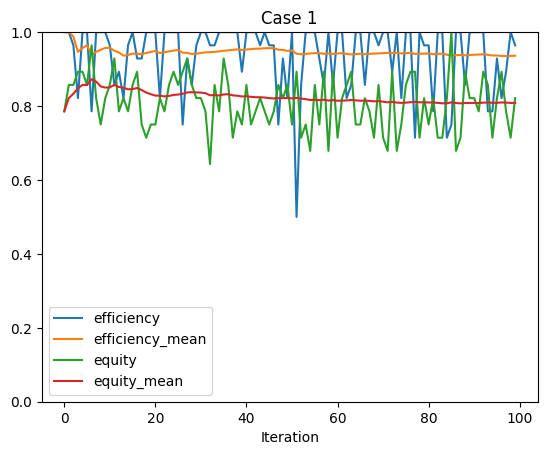

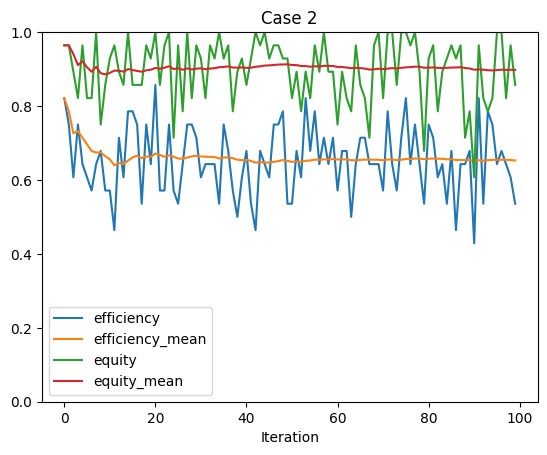

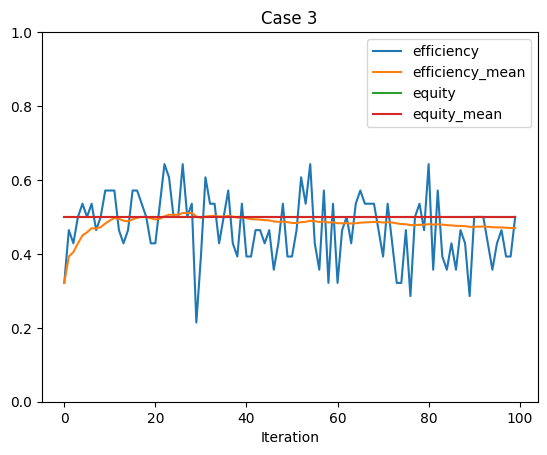

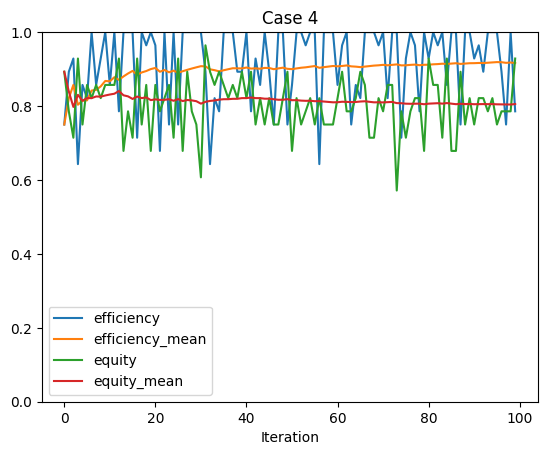

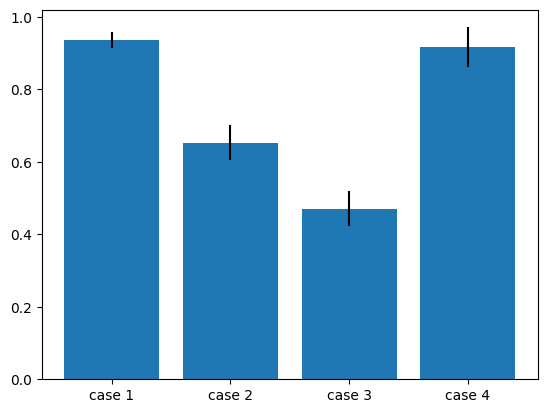

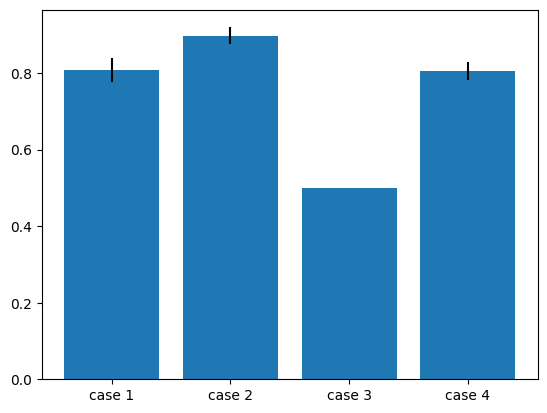

In [5]:
scenarios = [1,2,3,4]

eff_mean_arr = []
eff_mean_err_arr = []
eq_mean_arr = []
eq_mean_err_arr = []
case_labels = ['case 1','case 2','case 3','case 4']

for scenario in scenarios:
    efficiency = []
    efficiency_mean = []
    equity = []
    equity_mean = []
    gen = range(100)

    match scenario:
        case 1:
            func = run_admission_iter
        case 2:
            func = run_admission_iter
        case 3:
            func = scenario_3
        case 4:
            func = scenario_4

    for x in gen:
        d_x1 = []
        d_x2 = []
        a_x1 = []
        a_x2 = []
        for x in range(0,50):
            d_x1.append(disadvantaged_random())
            d_x2.append(disadvantaged_random())
            a_x1.append(advantaged_random())
            a_x2.append(advantaged_random())

        x_1 = a_x1 + d_x1
        x_2 = a_x2 + d_x2
        g = ['A' for x in range(0,50)] + ['D' for x in range(0,50)]

        students_df = pd.DataFrame({"x_1":x_1,
                                    "x_2":x_2,
                                    "g":g })
        students_df["f"] = students_df.apply(lambda x: 1 if (x["x_1"]==1 and x["x_2"]==1) else 0, axis=1)

        num_admitted_students = round(100*5/18)

        res = func(scenario,students_df=students_df,num_admitted_students=num_admitted_students)
        efficiency.append(res['efficiency'])
        efficiency_mean.append(np.mean(efficiency))
        equity.append(res['equity'])
        equity_mean.append(np.mean(equity))

    plt.plot(gen,efficiency,label="efficiency")
    plt.plot(gen,efficiency_mean,label="efficiency_mean")
    plt.plot(gen,equity,label="equity")
    plt.plot(gen,equity_mean,label="equity_mean")
    plt.xlabel("Iteration")
    plt.legend()
    plt.title('Case '+str(scenario))
    plt.ylim((0,1))
    plt.show()

    eff_mean_arr.append(efficiency_mean[-1])
    eff_mean_err_arr.append(np.std(efficiency_mean)*2)
    eq_mean_arr.append(equity_mean[-1])
    eq_mean_err_arr.append(np.std(equity_mean)*2)

    # print('efficiency mean: ',efficiency_mean[-1],' +/- ',np.std(efficiency_mean))
    # print('equity mean: ',equity_mean[-1],' +/- ',np.std(equity_mean))

effs_bar = plt.bar(case_labels,eff_mean_arr,yerr=eff_mean_err_arr)
plt.show()

eqs_bar = plt.bar(case_labels,eq_mean_arr,yerr=eq_mean_err_arr)
plt.show()

# Part II

PART II

Approach:
1. Define how the college admittance status and group membership of each Generation 1 student impacts the group membership of each Generation 2 student.
- Note: Assume asexual reproduction, each Generation 1 student produces 1 Generation 2 student that is influenced by their parent.

2. Define parameters for x_1 and x_2 probabilities for subsequent generations as influenced by group membership that is influenced by the previous generation's group membership and admittance to college.

3. Use the algorithm from Part I to simulate college admissions process for the next generation based on the previous generation's group membership and college admission status.

4. Repeat step 3. for 100-1000 generations.

5. Assess the social mobility (change in proportion of groups A and D over time) in all four scenarios.

6. Perform sensitivity analysis by varying the parameters of the model and then assessing the social mobility?

## Functions

- Generate parents and students df
- Make plot

In [6]:
# Initial the 1st generation

import numpy as np
import pandas as pd
import random

def run_admission_iter(students_df=None, scenario = "base", upgrade_prob=0.5 , degrade_prob = 0.33 ,seed=124):
    '''

    # This function will run to generate both 1st generation and nth generation

    # if 1st generation, g and admit will be None
        # g = 50%A+50%D, admit = based on f (1/0)

    # if nth generation, g and admit will be provided
        # parents admtted: 
            # parents group A --> 100%A, D --> 50% A, 50% D
        # parents not admtted:
            # parents group A --> 67%A,33%D, D --> 100%D
    # Input :
        # students_df : dataframe of students with x_1,x_2,g,f,admit 

    # Return:  new students_df, generated based on their parents

    
    '''

    # ---- Helper functions 

    # Generate group labels from parents
    def group_generator(students_df, upgrade_prob=upgrade_prob, degrade_prob = degrade_prob):
        if (students_df["f"] == 1 and students_df["g"] == 'A') or (students_df["f"] == 0 and students_df["g"] == 'D'):
            return students_df["g"]
        elif (students_df["f"] == 1 and students_df["g"] == 'D'):
            return np.random.choice(["A","D"], p = [upgrade_prob,1-upgrade_prob])
        elif (students_df["f"] == 0 and students_df["g"] == 'A') :
            return np.random.choice(["A","D"], p = [1-degrade_prob,degrade_prob])
        else:
            raise ValueError('Invalid group and f value')


    # ---- Main function

    # Group labels
    if students_df is None:
        new_g = ['A' for x in range(0,50)] + ['D' for x in range(0,50)]
    else:
        new_g = students_df.apply(group_generator, axis=1)
        new_g = new_g.sort_values(ascending = True) # order A-->D


    # x_i
    np.random.seed(seed)
    d_x1 = np.random.choice([0,1],p = [0.67,0.33],size=50,replace=True)
    d_x2 = np.random.choice([0,1],p = [0.67,0.33],size=50,replace=True)
    a_x1 = np.random.choice([0,1],p = [0.33, 0.67],size=50,replace=True)
    a_x2 = np.random.choice([0,1],p = [0.33, 0.67],size=50,replace=True)
    x_1 = np.concatenate((a_x1,d_x1))
    x_2 = np.concatenate((a_x2,d_x2))

    #print(len(x_1),len(x_2),len(new_g))

    students_df = pd.DataFrame({"x_1":x_1,"x_2":x_2, "g":new_g })

    # f
    
    if scenario == 'base':
        students_df["f"] = students_df.apply(lambda x: 1  if (x["x_1"]==1 and x["x_2"]==1) else 0, axis=1)
        # Rank --> admit
        students_df=students_df.sort_values(by=["f","g"],ascending=[False,False])
    
    elif scenario == 'scenario_2': # Not use x2 and do not use group membership information.
        students_df["f"] = students_df.apply(lambda x: 1 if (x["x_1"]==1 ) else 0, axis=1)
        students_df=students_df.sort_values(by=["f"],ascending=[False])
    
    elif scenario == 'scenario_3': # Not use x2, but use group membership information.
        students_df["f"] = students_df.apply(lambda x: 1  if (x["x_1"]==1 ) else 0, axis=1)
        students_df=students_df.sort_values(by=["f","g"],ascending=[False,False])

    elif scenario == 'scenario_4': #Use x2 for students in the disadvantaged group and do not use group membership information otherwise.
        students_df["f"] = students_df.apply(lambda x: 1 if ((x["g"] == 'D' and x["x_1"] == 1 and x["x_2"] == 1) or
                                                                (x["g"] == 'A' and x["x_1"] == 1)) else 0, axis=1)
        students_df = students_df.sort_values(by=["f"], ascending=[False])

    num_admit = int(students_df.shape[0]*5/18)
    num_reject = students_df.shape[0] - num_admit

    students_df["admit"] = [1 for i in range(num_admit)] + [0 for i in range(num_reject)]


    return students_df.reset_index(drop=True)




In [7]:
# Plot

def plot_effi_eq(eval_df):

    plt.figure(figsize=(20, 5))
    plt.plot(eval_df.index,eval_df["efficiency"],color='royalblue',label="efficiency", linewidth=2, alpha=0.8)
    plt.plot(eval_df.index,eval_df["equity"],color='darkorange',label="equity", linewidth=2, alpha=0.8)
    plt.xlabel("Generation")
    plt.ylabel("Value")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.title("Efficiency & Equity Over Generations", fontsize=16)
    plt.legend(fontsize=12, loc='upper right')
    plt.ylim((0,1))
    plt.show()

def plot_groups_prob(eval_df):
    plt.figure(figsize=(20, 5))
    plt.plot(eval_df.index,eval_df["prob_A"],color='royalblue',label='Prob_A', linewidth=2, alpha=0.8)
    plt.plot(eval_df.index,eval_df["prob_D"],color='darkorange',label='Prob_D', linewidth=2, alpha=0.8)
    plt.xlabel("Generation")
    plt.ylabel("Value")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.title("Prob of Group A and D Over Generations", fontsize=16)
    plt.legend(fontsize=12, loc='upper right')
    plt.ylim((0,1))
    plt.show()



    

## Implementation

-- Initial 1st generation
-- Keep model of group change consistent, compare the four scenario
-- Keep scenairo consistent, compare changing model parameter
-- Model base: degrade_prob = 0.3, upgrade_prob = 0.5
-- Base scenario: use I(x1=1, x2=1)=1, and group to rank candidates then select quantified students.

In [8]:
# Initial the 1st generation
df_0 = run_admission_iter(seed=7)
df_0 = df_0.copy()


### Base model + Default scenario

**Results for Base model + Default scenario**


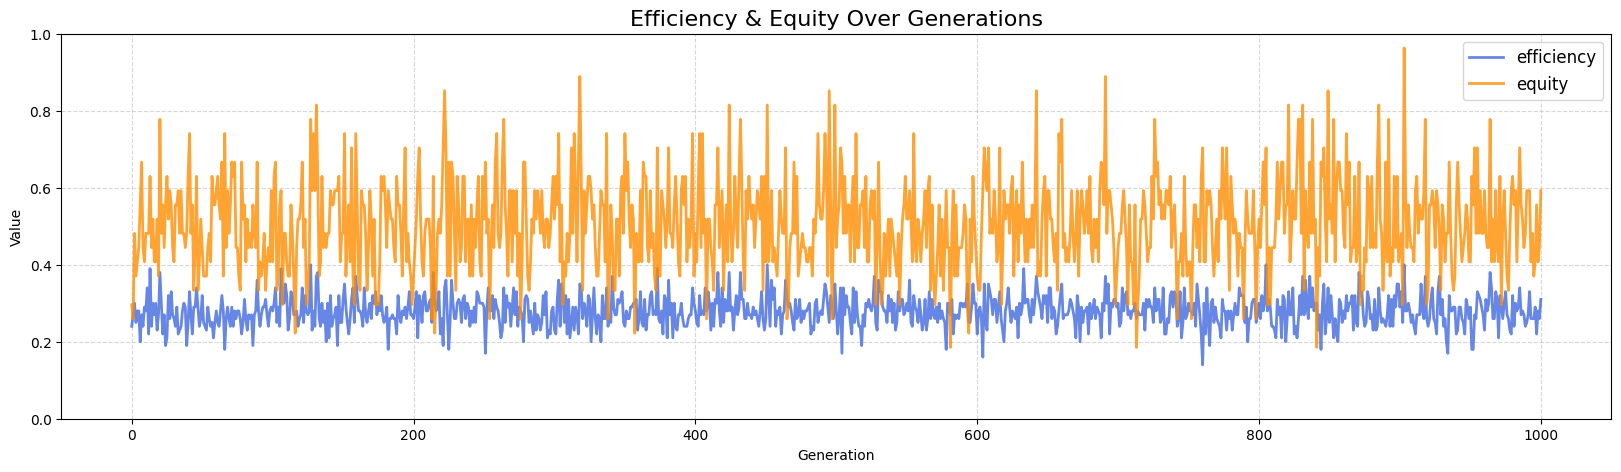

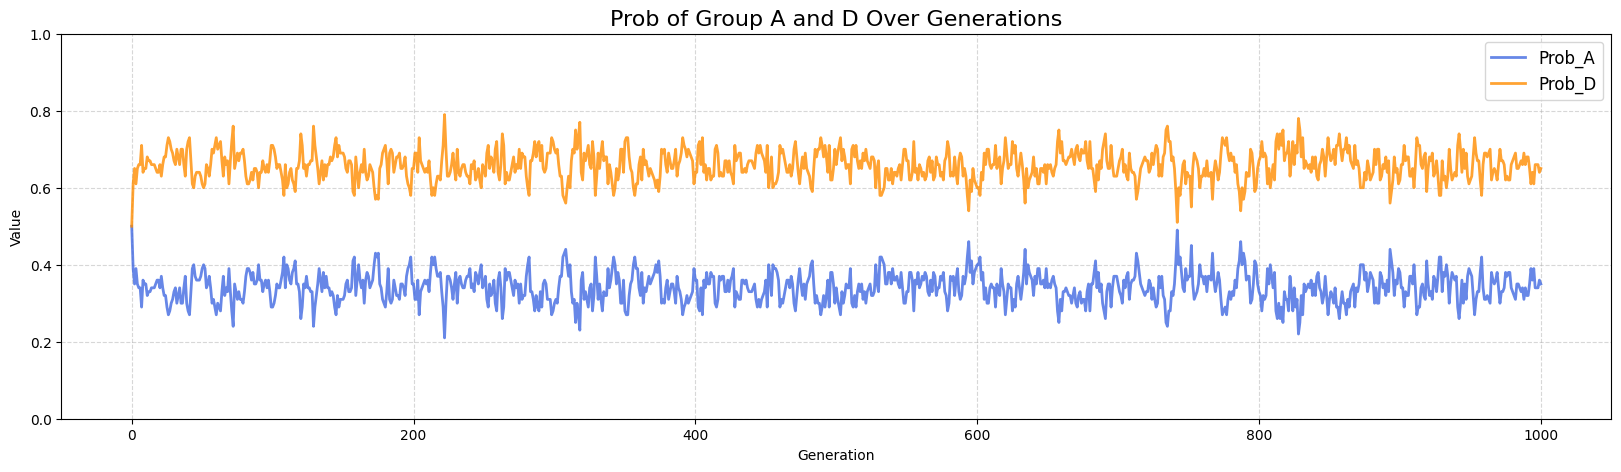

In [9]:
# Base model + Default scenario
df_1 = df_0.copy()
# Initial evaluation metrics for each generation
efficiency = [df_0["f"].mean()] # mean f
equity = [df_0.loc[(df_0["admit"]==1) & (df_0["g"]=="D"),"g"].shape[0]/df_0.loc[df_0["admit"]==1,"g"].shape[0]] # fraction of admitted students from group D
prob_A = [df_0.loc[df_0["g"]=="A"].shape[0]/df_0.shape[0]] # fraction of students from group A
prob_D = [df_0.loc[df_0["g"]=="D"].shape[0]/df_0.shape[0]] # fraction of students from group D

for i in range(1000):
    df_1 = run_admission_iter(students_df = df_1, seed=i+8)
    #print(df_0.head())
    efficiency.append(df_1["f"].mean())
    equity.append(df_1.loc[(df_1["admit"]==1) & (df_1["g"]=="D"),"g"].shape[0]/df_1.loc[df_1["admit"]==1,"g"].shape[0])
    prob_A.append(df_1.loc[df_1["g"]=="A"].shape[0]/df_1.shape[0])
    prob_D.append(df_1.loc[df_1["g"]=="D"].shape[0]/df_1.shape[0])

eval_df_00 = pd.DataFrame({"generation":range(len(efficiency)),"efficiency":efficiency,"equity":equity,"prob_A":prob_A,"prob_D":prob_D})

#eval_df_00.head(10)
print("**Results for Base model + Default scenario**")
plot_effi_eq(eval_df_00)
plot_groups_prob(eval_df_00)

### Base model + Scenario 2

** Results for Base model + Scenario 2 **


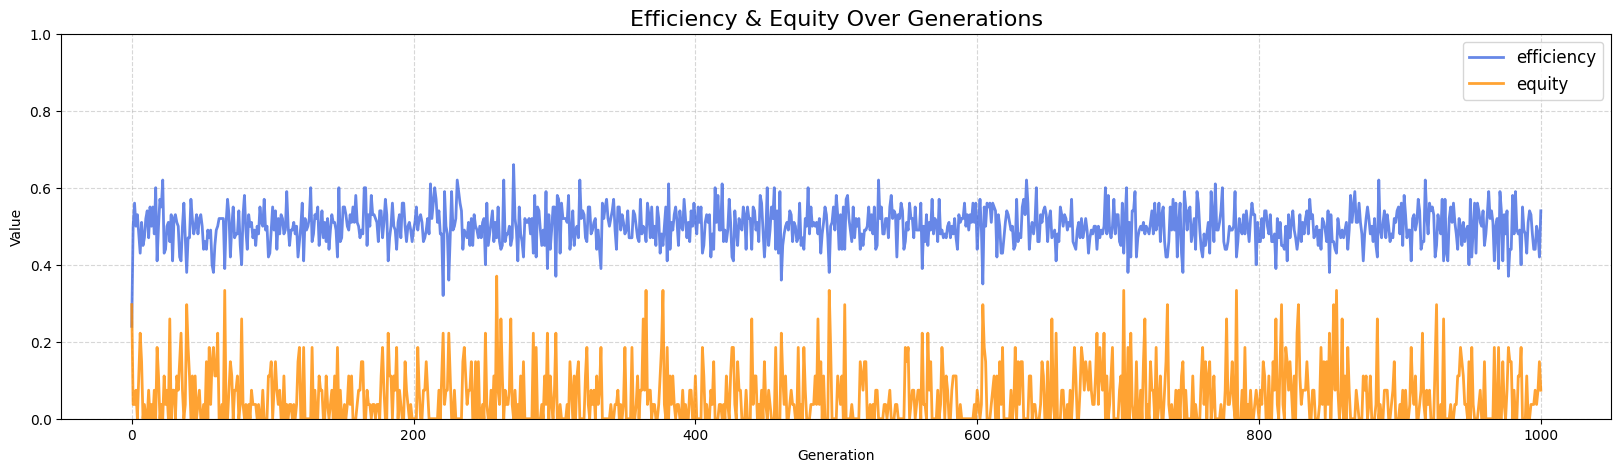

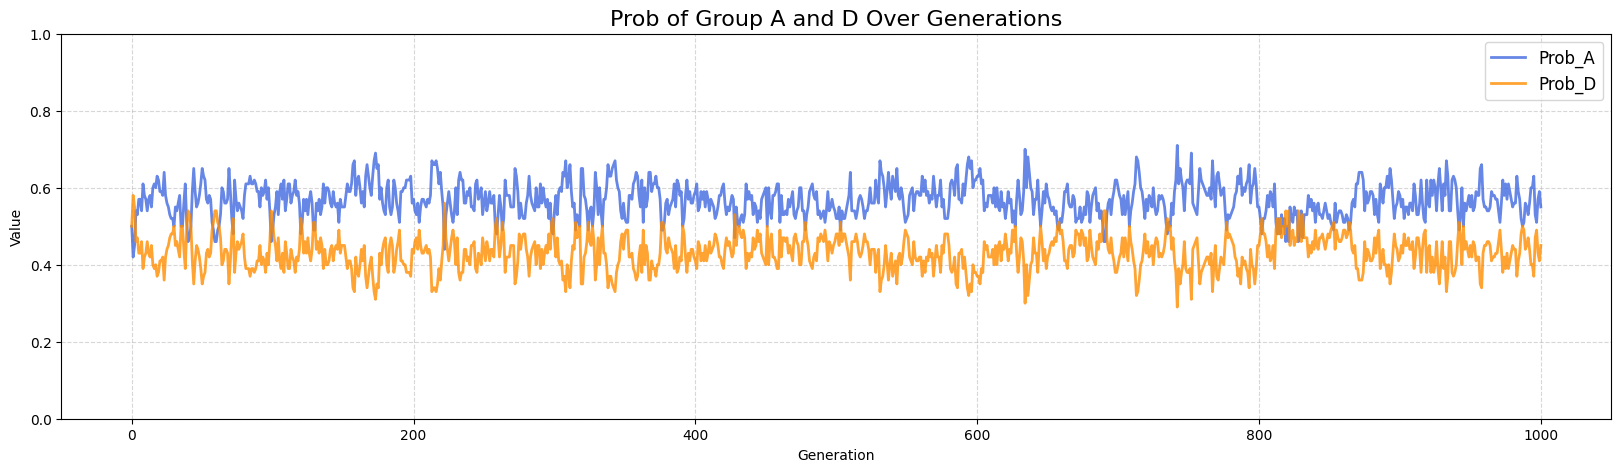

In [10]:
# Base model +  scenario2
df_1 = df_0.copy()
# Initial evaluation metrics for each generation
efficiency = [df_0["f"].mean()] # mean f
equity = [df_0.loc[(df_0["admit"]==1) & (df_0["g"]=="D"),"g"].shape[0]/df_0.loc[df_0["admit"]==1,"g"].shape[0]] # fraction of admitted students from group D
prob_A = [df_0.loc[df_0["g"]=="A"].shape[0]/df_0.shape[0]] # fraction of students from group A
prob_D = [df_0.loc[df_0["g"]=="D"].shape[0]/df_0.shape[0]] # fraction of students from group D

for i in range(1000):
    df_1 = run_admission_iter(students_df = df_1, scenario="scenario_2",seed=i+8)
    #print(df_1.head())
    efficiency.append(df_1["f"].mean())
    equity.append(df_1.loc[(df_1["admit"]==1) & (df_1["g"]=="D"),"g"].shape[0]/df_1.loc[df_1["admit"]==1,"g"].shape[0])
    prob_A.append(df_1.loc[df_1["g"]=="A"].shape[0]/df_1.shape[0])
    prob_D.append(df_1.loc[df_1["g"]=="D"].shape[0]/df_1.shape[0])

eval_df_01 = pd.DataFrame({"generation":range(len(efficiency)),"efficiency":efficiency,"equity":equity,"prob_A":prob_A,"prob_D":prob_D})

#eval_df_00.head(10)
print("** Results for Base model + Scenario 2 **")
plot_effi_eq(eval_df_01)
plot_groups_prob(eval_df_01)

### Base model + Scenario 3

** Results for Base model + Scenario 3 **


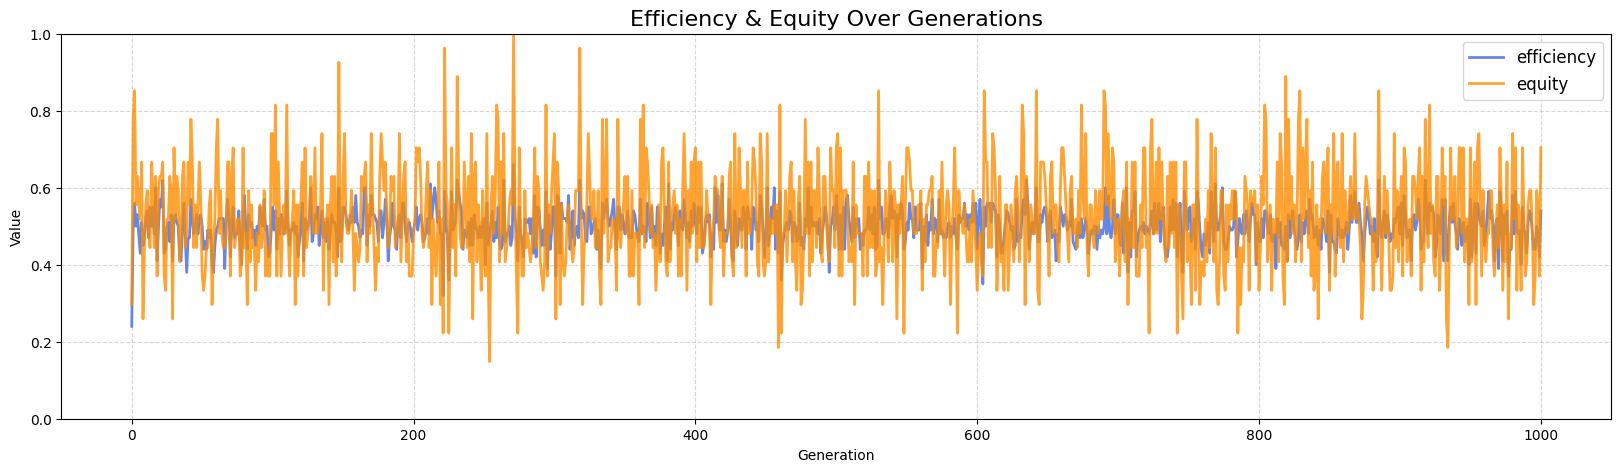

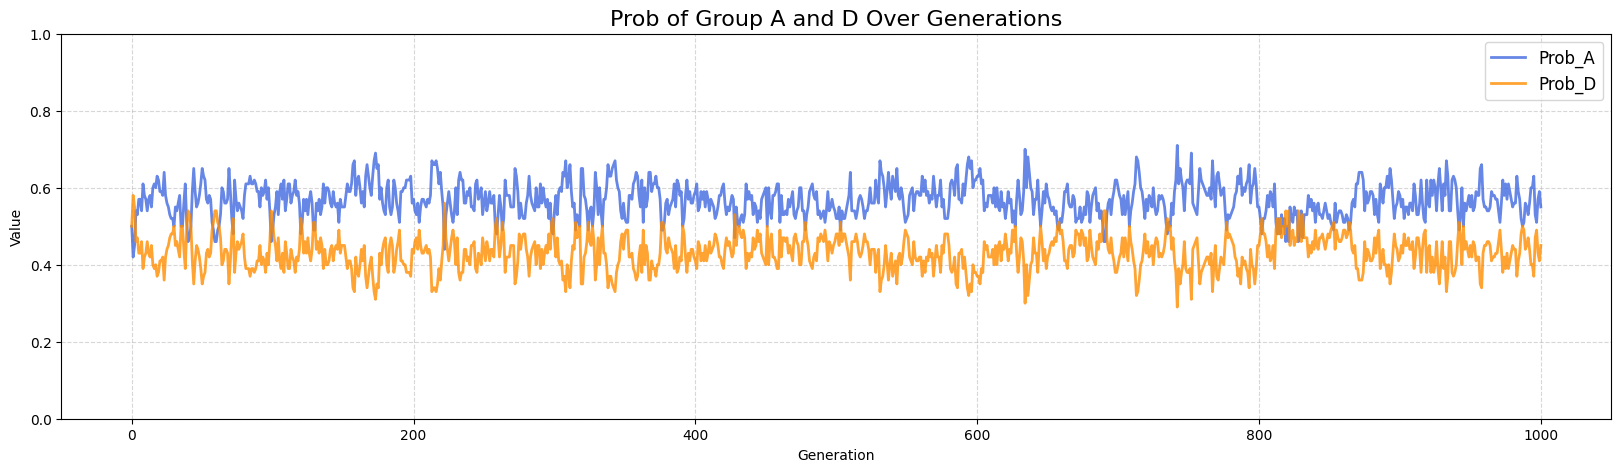

In [11]:
# Base model +  scenario3
df_1 = df_0.copy()
# Initial evaluation metrics for each generation
efficiency = [df_0["f"].mean()] # mean f
equity = [df_0.loc[(df_0["admit"]==1) & (df_0["g"]=="D"),"g"].shape[0]/df_0.loc[df_0["admit"]==1,"g"].shape[0]] # fraction of admitted students from group D
prob_A = [df_0.loc[df_0["g"]=="A"].shape[0]/df_0.shape[0]] # fraction of students from group A
prob_D = [df_0.loc[df_0["g"]=="D"].shape[0]/df_0.shape[0]] # fraction of students from group D

for i in range(1000):
    df_1 = run_admission_iter(students_df = df_1, scenario="scenario_3",seed=i+8)
    #print(df_1.head())
    efficiency.append(df_1["f"].mean())
    equity.append(df_1.loc[(df_1["admit"]==1) & (df_1["g"]=="D"),"g"].shape[0]/df_1.loc[df_1["admit"]==1,"g"].shape[0])
    prob_A.append(df_1.loc[df_1["g"]=="A"].shape[0]/df_1.shape[0])
    prob_D.append(df_1.loc[df_1["g"]=="D"].shape[0]/df_1.shape[0])

eval_df_02 = pd.DataFrame({"generation":range(len(efficiency)),"efficiency":efficiency,"equity":equity,"prob_A":prob_A,"prob_D":prob_D})

#eval_df_00.head(10)
print("** Results for Base model + Scenario 3 **")
plot_effi_eq(eval_df_02)
plot_groups_prob(eval_df_02)

### Base model + Scenario 4

** Results for Base model + Scenario 4 **


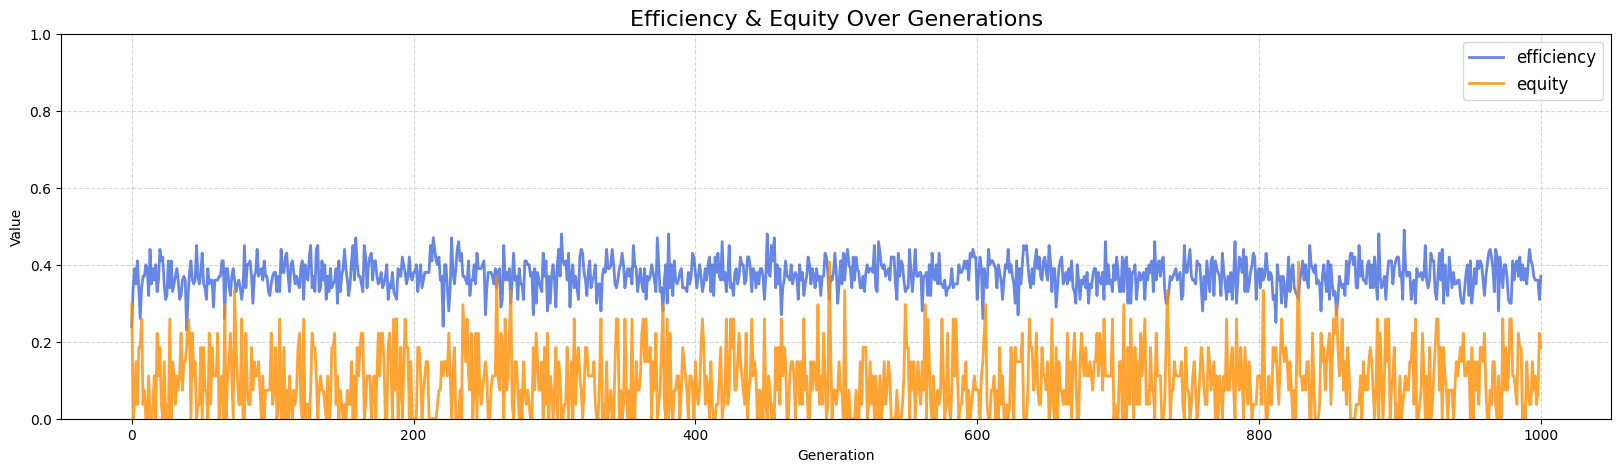

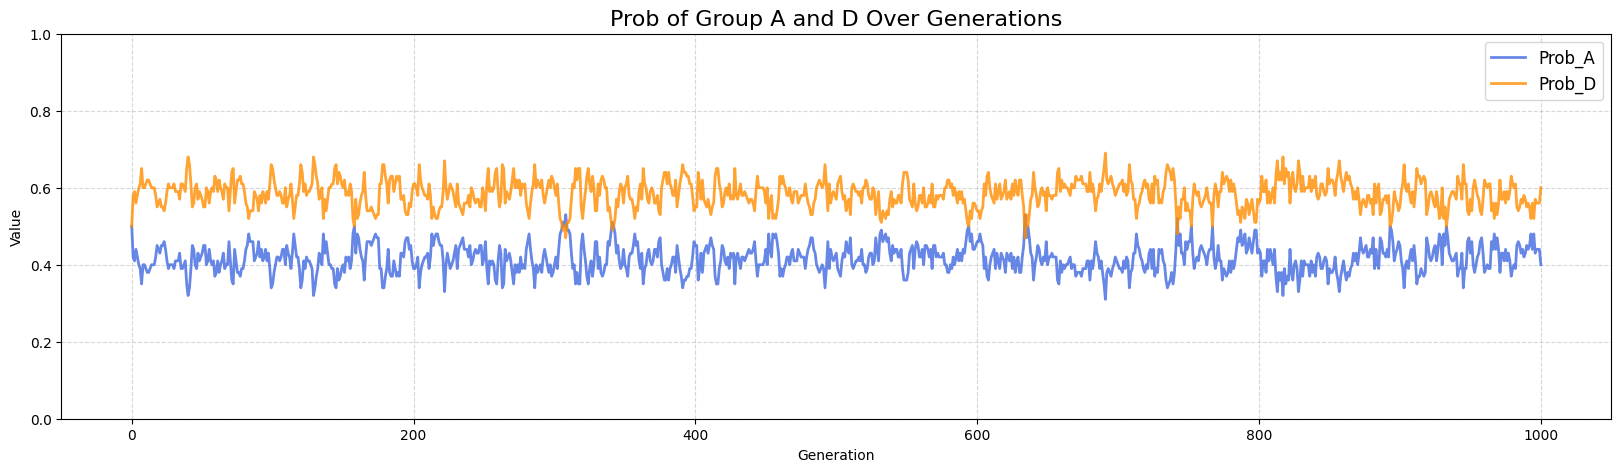

In [12]:
# Base model +  scenario3
df_1 = df_0.copy()
# Initial evaluation metrics for each generation
efficiency = [df_0["f"].mean()] # mean f
equity = [df_0.loc[(df_0["admit"]==1) & (df_0["g"]=="D"),"g"].shape[0]/df_0.loc[df_0["admit"]==1,"g"].shape[0]] # fraction of admitted students from group D
prob_A = [df_0.loc[df_0["g"]=="A"].shape[0]/df_0.shape[0]] # fraction of students from group A
prob_D = [df_0.loc[df_0["g"]=="D"].shape[0]/df_0.shape[0]] # fraction of students from group D

for i in range(1000):
    df_1 = run_admission_iter(students_df = df_1, scenario="scenario_4",seed=i+8)
    #print(df_1.head())
    efficiency.append(df_1["f"].mean())
    equity.append(df_1.loc[(df_1["admit"]==1) & (df_1["g"]=="D"),"g"].shape[0]/df_1.loc[df_1["admit"]==1,"g"].shape[0])
    prob_A.append(df_1.loc[df_1["g"]=="A"].shape[0]/df_1.shape[0])
    prob_D.append(df_1.loc[df_1["g"]=="D"].shape[0]/df_1.shape[0])

eval_df_03 = pd.DataFrame({"generation":range(len(efficiency)),"efficiency":efficiency,"equity":equity,"prob_A":prob_A,"prob_D":prob_D})

#eval_df_00.head(10)
print("** Results for Base model + Scenario 4 **")
plot_effi_eq(eval_df_03)
plot_groups_prob(eval_df_03)

### Model 2 + Default scenario

**Results for Model 2 + Default scenario**


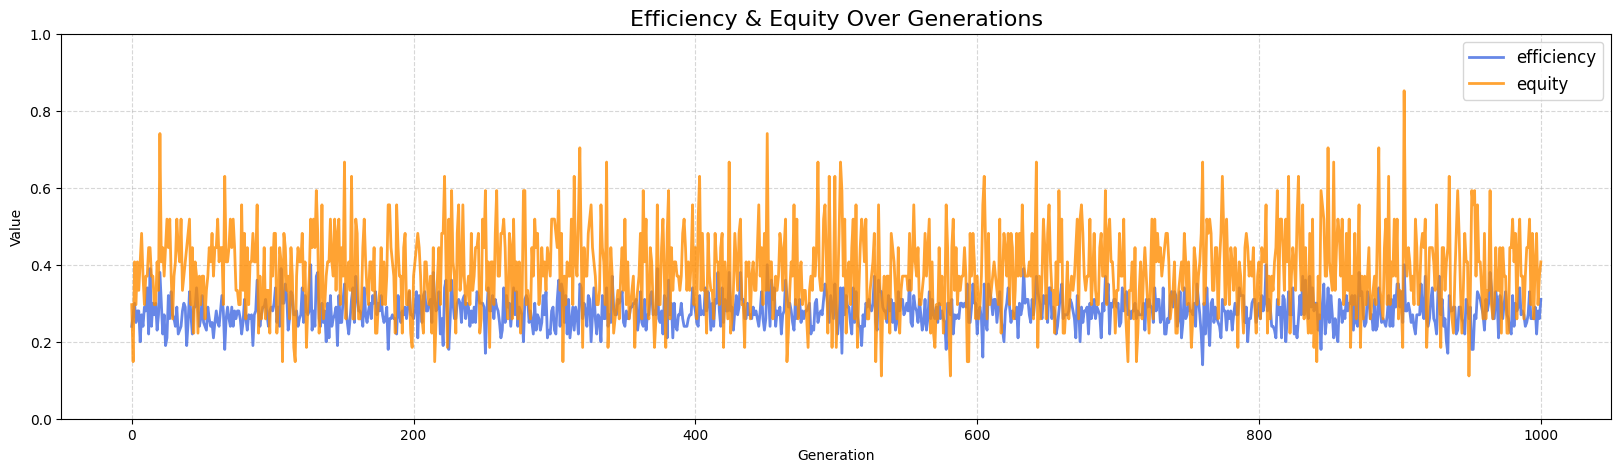

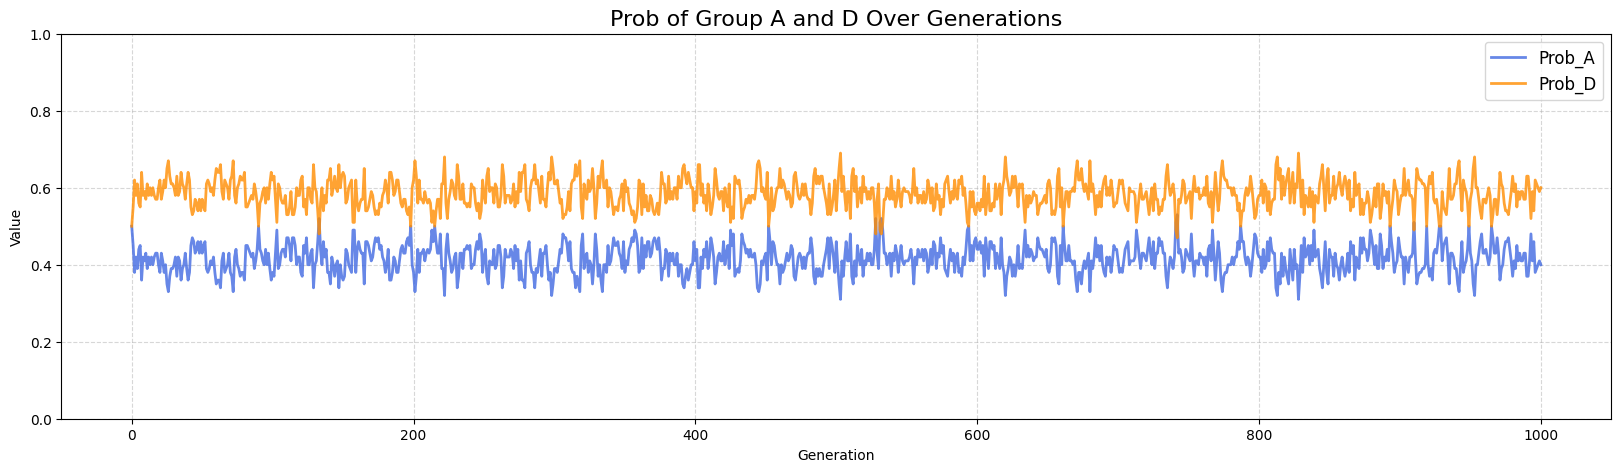

In [13]:
# Base model + Default scenario
df_1 = df_0.copy()
# Initial evaluation metrics for each generation
efficiency = [df_0["f"].mean()] # mean f
equity = [df_0.loc[(df_0["admit"]==1) & (df_0["g"]=="D"),"g"].shape[0]/df_0.loc[df_0["admit"]==1,"g"].shape[0]] # fraction of admitted students from group D
prob_A = [df_0.loc[df_0["g"]=="A"].shape[0]/df_0.shape[0]] # fraction of students from group A
prob_D = [df_0.loc[df_0["g"]=="D"].shape[0]/df_0.shape[0]] # fraction of students from group D

for i in range(1000):
    df_1 = run_admission_iter(students_df = df_1, seed=i+8, upgrade_prob=0.83)
    #print(df_0.head())
    efficiency.append(df_1["f"].mean())
    equity.append(df_1.loc[(df_1["admit"]==1) & (df_1["g"]=="D"),"g"].shape[0]/df_1.loc[df_1["admit"]==1,"g"].shape[0])
    prob_A.append(df_1.loc[df_1["g"]=="A"].shape[0]/df_1.shape[0])
    prob_D.append(df_1.loc[df_1["g"]=="D"].shape[0]/df_1.shape[0])

eval_df_10 = pd.DataFrame({"generation":range(len(efficiency)),"efficiency":efficiency,"equity":equity,"prob_A":prob_A,"prob_D":prob_D})

#eval_df_00.head(10)
print("**Results for Model 2 + Default scenario**")
plot_effi_eq(eval_df_10)
plot_groups_prob(eval_df_10)

### Model 3 + Default scenario

**Results for Model 3 + Default scenario**


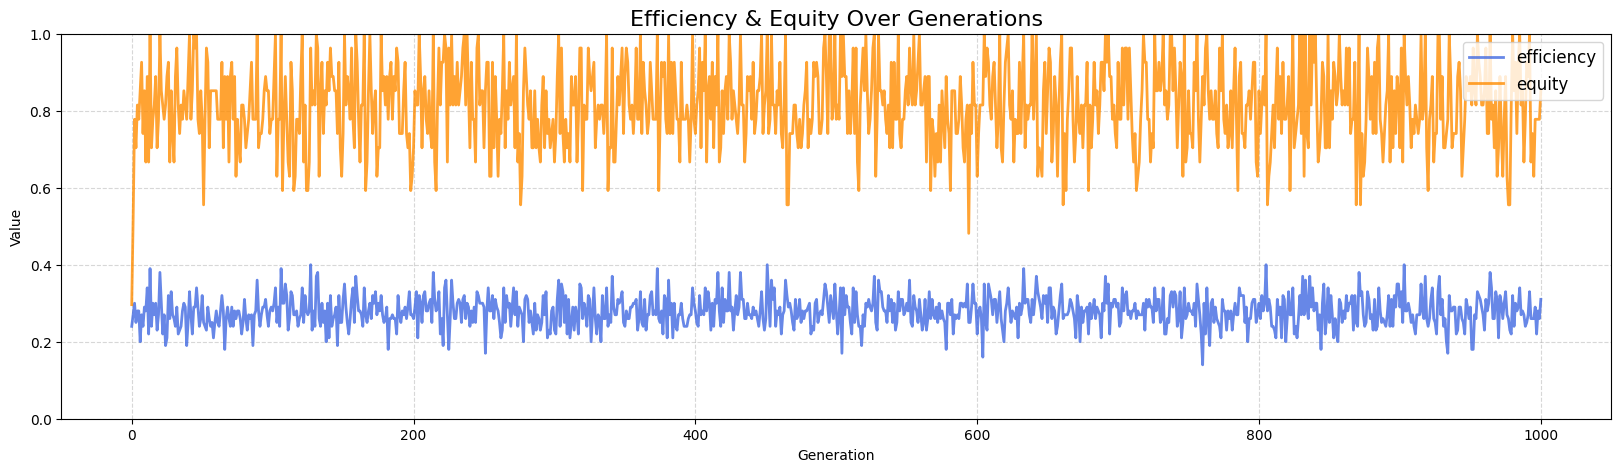

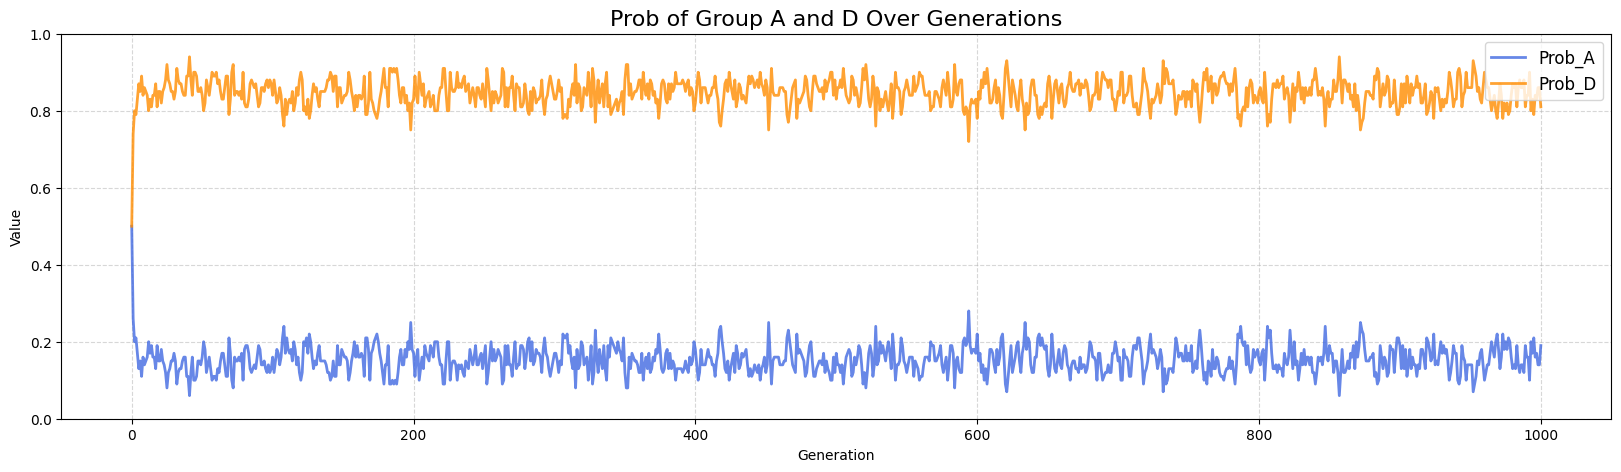

In [14]:
# Base model + Default scenario
df_1 = df_0.copy()
# Initial evaluation metrics for each generation
efficiency = [df_0["f"].mean()] # mean f
equity = [df_0.loc[(df_0["admit"]==1) & (df_0["g"]=="D"),"g"].shape[0]/df_0.loc[df_0["admit"]==1,"g"].shape[0]] # fraction of admitted students from group D
prob_A = [df_0.loc[df_0["g"]=="A"].shape[0]/df_0.shape[0]] # fraction of students from group A
prob_D = [df_0.loc[df_0["g"]=="D"].shape[0]/df_0.shape[0]] # fraction of students from group D

for i in range(1000):
    df_1 = run_admission_iter(students_df = df_1, seed=i+8, upgrade_prob=0.33, degrade_prob=0.83)
    #print(df_0.head())
    efficiency.append(df_1["f"].mean())
    equity.append(df_1.loc[(df_1["admit"]==1) & (df_1["g"]=="D"),"g"].shape[0]/df_1.loc[df_1["admit"]==1,"g"].shape[0])
    prob_A.append(df_1.loc[df_1["g"]=="A"].shape[0]/df_1.shape[0])
    prob_D.append(df_1.loc[df_1["g"]=="D"].shape[0]/df_1.shape[0])

eval_df_20 = pd.DataFrame({"generation":range(len(efficiency)),"efficiency":efficiency,"equity":equity,"prob_A":prob_A,"prob_D":prob_D})

#eval_df_00.head(10)
print("**Results for Model 3 + Default scenario**")
plot_effi_eq(eval_df_20)
plot_groups_prob(eval_df_20)